# TODO

## Basics:
* plotting mit pandas, matplotlib, seaborn und bokeh wdh
* revisions verstehen! ist im state immer die letzte? wo sind die ersten? history?
  * false attempts bei textfelder

## Analyse
### Paket
* wie viele SuS wie weit gekommen (bedenken, dass kein Präsenz)
  * grafik fürs ganze paket in prozent
  * anzahl einzelner aufgaben --> boxplot von df["_id"].value_counts()

### Items (für alle Aufgaben, aber besonders MA)
* [x] für Selbsteinschätzung:
  * [x] min, max mean, median, streuung (IQD, std)
  * [x] boxplot
  * violinplot
  * ausreißer
  * selbsteinschätzung korrelieren mit Antworten?
* MC
  * [x] balkendiagramm
  * false attempts? historie? 
  * ratio richtig zu falsch
  * prozent als tortendiagramm?
  * welche Antworten war die schweren? wo haben SuS fehler gemacht? --> misskonzepte / schlechte formulierungen?
* freetext
  * prozent angenommen vs zurückgegeben, wie oft zurückgegeben --> wo am öftesten?
  * wie lang im durchschnitt die antworten
  * bewertung der lehrer
  * nach eigenen kategorien checken
  * wie oft revisions
  * historie
  * (response time lehrer)
* textfelder (wie mc?)
* (surveys)
 
#### Durations
* Dauer
  * jeder Aufgabe: 
    * mean, median, std
    * histogram dauer für jede aufgabe
    * längste aufgabe
  * jedes Aufgabentyps (siehe oben)

#### Rest
* Anzahl Hilfeanfragen?
* (wie wird der chat genutzt?)

### Lernfortschrittsanalyse der Schüler
* T0 und T1 vergleich
  * selbsteinschätzung vorher nachher
  * freitext einer Klasse / random gezogen aus allen. nach Kategorien?
  * MC antworten & transfer --> wirklich verstanden?
* (Dauer für Schüler vergleichen)
  * hist aller Aufgaben, bzw nach Aufgabentyp, bzw relativ zum Klassendurchschnitt dieser Aufgaben!
* (stärke eines schülers evaluieren: duration. richtig vs falsch/false attempts. hilfe rufen vs hilfe geben.)

## Aufbereitung
* Code cleanen
* vllt eine interactive bokeh app machen, die ich den profs noch zur verfügung stelle?
* öffentlich machen?

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from numpy.random import randn
from statistics import mode
%matplotlib inline

In [2]:
pupils = json.load(open('pupils.json', 'r'))    # result will be a python dictionary

#jeder entry ist ein schüler: zB data[0]
len(pupils)
#2715

2946

# Aufbau der Daten

* _id
* classId
* userId
* companyId
* partner
* lang
* username
* shownTaskSeries
* currentTaskSeries
* solvedTaskSeries
    * [] liste mit allen solvedTaskSeries
       * taskSeriesId
       * currentSections
          * [] Liste mit allen Sections
             * currentSubSections
                * []
                   * duration (in sekunden)
                   * exercise
                      * state:
                         * text bei freitext in p tags
                         * 0, 1, 0... bei survey
                         * false, true, false bei MC
                      * submitted: true
                      * history: wahrscheinlich alte versionen bei freetext
                      * subType “freetext”, “survey”, “multipleChoice”
                      * falseAttempts bei MC: bool array mit erster lösung
                      * evaluation: (bool) bei freetext und MC
                         * “false” bei mc wenn falsche lösung und keine tipps → direkt musterlösung
                         * “correct” bei mc wenn richtige lösung
                         * “pending” bei freitext, wenn lehrer noch nicht bewertet
                      * rating: bei freetext
      * sectionIdx
      * subSectionIdx
      * stage
      * wentActive
      * lastActive
      * created
* revisions
   * _id
   * taskSeriesId
   * sectionIdx
   * subSectionIdx
   * begin
   * accepted
* workspaceContent
   * type: 'revision'
   * 'id': 'For-1_0_1'
* chat
   * messages
      * [] liste mit allen messages
         * date
         * sentBy: zB "auto"
         * message: string mit message
   * readUpTo
* assists
* experience
* lastNotificationUpdate

# Klassen wählen, die das KI Paket gemacht haben

In [3]:
# taskseriesIDs vom KI Paket:
KI_taskseries_ids = ["AI-1-v2", "AI-2-v2", "AI-3-v2", "AI-4-v2", "ML-1", "ML-2", "ML-3", "Classification-1", "Clustering-1", "Classification-2", "Clustering-2", "LimitsML", "EvalML", "Impact-1", "Impact-2", "Impact-3", "Impact-4", "AIClosing"]

classIDsKI = []
pupilsKI = []

for pupilnumber in range(len(pupils)): #für jeden schüler
    for tasknumber in range(len(pupils[pupilnumber]["solvedTaskSeries"])): #für jede seiner tasks
        if(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["taskSeriesId"] in KI_taskseries_ids):
            for sectionnumber in range(len(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"])): #für diese tasks, alle sections
                for subsectionnumber in range(len(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"][sectionnumber]["currentSubSections"])):
                    if("exercise" in pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"][sectionnumber]["currentSubSections"][subsectionnumber].keys()):
                        if pupils[pupilnumber]["classId"] not in classIDsKI:
                            classIDsKI.append(pupils[pupilnumber]["classId"])
                        if pupils[pupilnumber] not in pupilsKI:
                            pupilsKI.append(pupils[pupilnumber])

KI_classes = {classID: {"count": 0} for classID in classIDsKI}

for pupil in pupilsKI:
    KI_classes[pupil["classId"]]["count"] += 1

print(KI_classes)
print("")

# Jetzt nur die Klassen mit genügend SuS auswählen
final_pupils_KI = []
min_class_size = 10

for pupil in pupilsKI:
    if(KI_classes[pupil["classId"]]["count"] >= min_class_size):
        final_pupils_KI.append(pupil)

print("Zur Zeit gibt es " + str(len(final_pupils_KI)) + " sus, die das KI Paket bearbeitet haben")

{'uxfuiLT4xZA6yvE6L': {'count': 2}, 'qFEyvypMn4sAwLwtc': {'count': 26}, 'y7j9eKDPsqNkAycuy': {'count': 1}, '6Z2MmkKQKebb7nz8P': {'count': 3}, '4fyXxCKaLbCBaPbYE': {'count': 1}, 'xYWgeSPkADwSmhdmm': {'count': 1}, 'GkQSJvPTRWsLnpyR9': {'count': 14}}

Zur Zeit gibt es 40 sus, die das KI Paket bearbeitet haben


# Alle von SuS bearbeitete Aufgaben im KI Paket in einen DF

In [16]:
tasktypes = ["blockly", "multipleChoice", "freetext", "survey", "inputField", "surveySlider", "noTask"]
exercise_keys = ['state', 'submitted', 'history', 'subType', 'evaluation', 'falseAttempts', 'hintsTaken', 'rating', 'teacherFeedback']

# TODO: nehme hier alle Aufgaben von SuS, die das KI Paket bearbeitet haben, nicht nur diese Inhalte --> einschränken?

columns = ["pupilId", "taskId", "taskSeriesId"] + exercise_keys
pupil_df = pd.DataFrame(columns=columns)

row_nr = 0
for pupil in final_pupils_KI:
    for task in pupil["solvedTaskSeries"]:
        sec_nr = 1
        for section in task["currentSections"]:
            subsec_nr = 1
            for subsection in section["currentSubSections"]:
                # eine neue Zeile hinzufügen für jede bearbeitete Aufgabe und id columns füllen
                #df = df.append({"pupilId": pupil["_id"], "taskId": str(task["taskSeriesId"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': task["taskSeriesId"], "sec_nr": sec_nr, "subsec_nr": subsec_nr}, ignore_index=True)
                pupil_df = pupil_df.append({"pupilId": pupil["_id"], "taskId": str(task["taskSeriesId"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': task["taskSeriesId"]}, ignore_index=True)
                subsec_nr += 1
                if("exercise" in subsection.keys()):
                    # hier wird der eigentliche state der aufgabe in die reihe eingetragen
                    for key in subsection["exercise"].keys():
                        pupil_df.at[row_nr, key] = subsection["exercise"][key]
                row_nr += 1
            sec_nr +=1
    
# aufgaben loswerden, die nicht submitted wurden!
pupil_df.dropna(subset=['submitted'], inplace=True)

#die antworten der einen falschen aufgabe berichtigen
for index in pupil_df.index:
    if(pupil_df.loc[index, "taskId"] == "Classification-2-1-5"):
        if ("2" in str(pupil_df.loc[index, "falseAttempts"])): #die SuS, die es eigentlich richtig hatten
            pupil_df.loc[index, "falseAttempts"] = np.nan
            pupil_df.loc[index, "evaluation"] = "correct"
        elif(pupil_df.loc[index, "pupilId"]=="gooproPtWeTH6dtcB"): #der eine schüler, der es falsch hatte
            pupil_df.loc[index, "falseAttempts"] = [str(df.loc[index, "state"])]
            pupil_df.loc[index, "evaluation"] = "false"

pupil_df.head()



,pupilId,taskId,taskSeriesId,state,submitted,history,subType,evaluation,falseAttempts,hintsTaken,rating,teacherFeedback
0,bniRycMi5bwrXjvGy,AI-1-v2-1-1,AI-1-v2,92,True,[],surveySlider,NaN,NaN,NaN,NaN,NaN
1,bniRycMi5bwrXjvGy,AI-1-v2-1-2,AI-1-v2,"<p>Künstliche Intelligenz ist ein Algorithmus,...",True,[],freetext,correct,NaN,NaN,"{'content': 3, 'format': 5, 'creativity': 4}","Inhaltlich gut, etwas genauer antworten. Muste..."
2,bniRycMi5bwrXjvGy,AI-1-v2-2-1,AI-1-v2,"[0, 0, 1, 0, 0]",True,[],survey,NaN,NaN,NaN,NaN,NaN
4,bniRycMi5bwrXjvGy,AI-2-v2-1-1,AI-2-v2,"[True, True, False, True]",True,[],multipleChoice,correct,NaN,NaN,NaN,NaN
6,bniRycMi5bwrXjvGy,AI-3-v2-1-1,AI-3-v2,"[False, False, False]",True,[],multipleChoice,correct,NaN,NaN,NaN,NaN


In [5]:
#taskSeries Laden
taskSeries = json.load(open('taskSeries.json', 'r'))    # result will be a python dictionary

In [71]:
#KI_taskseries_ids = ["AI-1-v2", "AI-2-v2", "AI-3-v2", "AI-4-v2", "ML-1", "ML-2", "ML-3", "Classification-1", "Clustering-1", "Classification-2", "Clustering-2", "LimitsML", "EvalML", "Impact-1", "Impact-2", "Impact-3", "Impact-4", "AIClosing"]
"""
'AI-1-v2-1-1', 'AI-1-v2-1-2', 'AI-1-v2-2-1', 'AI-2-v2-1-1',
       'AI-3-v2-1-1', 'AI-3-v2-1-2', 'AI-4-v2-1-1', 'AI-4-v2-1-2',
       'AI-4-v2-1-3', 'AI-4-v2-1-4', 'AI-4-v2-1-5', 'ML-1-1-1',
       'ML-1-1-2', 'ML-1-1-3', 'ML-1-1-4', 'ML-2-1-1', 'ML-2-1-2',
       'ML-2-1-3', 'ML-3-1-1', 'ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4',
       'Classification-1-1-1', 'Clustering-1-1-1', 'Clustering-1-1-2',
       'Clustering-1-1-3', 'Clustering-1-1-4', 'Classification-2-1-1',
       'Classification-2-1-2', 'Classification-2-1-3',
       'Classification-2-1-4', 'Classification-2-1-5',
       'Classification-2-1-6', 'Classification-2-1-7',
       'Classification-2-1-8', 'Clustering-2-1-1', 'LimitsML-1-1',
       'LimitsML-1-2', 'EvalML-1-1', 'EvalML-1-2', 'EvalML-1-3',
       'EvalML-1-4', 'EvalML-1-5', 'EvalML-1-6', 'EvalML-1-7',
       'EvalML-1-8', 'EvalML-1-9', 'Impact-1-1-1', 'Impact-2-1-1',
       'Impact-2-1-2', 'Impact-2-1-3', 'Impact-2-1-4', 'Impact-2-1-5',
       'Impact-2-1-6', 'Impact-2-1-7', 'Impact-3-1-1', 'Impact-3-1-2',
       'Impact-3-1-3', 'Impact-4-1-1', 'AIClosing-1-1', 'AIClosing-1-2',
       'AIClosing-1-3', 'AIClosing-1-4', 'AIClosing-1-5', 'AIClosing-1-6',
       'AIClosing-1-7', 'AIClosing-1-8'
"""
interaction_subtypes = ['multipleChoice', 'blockly', 'surveySlider', 'survey', 'inputField', 'freetext']

columns = ["taskId", "question", "answers", "minLabel", "maxLabel", "hints", "sampleSolution"]
task_df = pd.DataFrame(columns=columns)

row_nr = 0
for taskSerie in taskSeries:
    sec_nr = 1
    if taskSerie["_id"] in KI_taskseries_ids:
        for section in taskSerie["sections"]:
            subsec_nr = 1
            for subsection in section["subSections"]:
                for elem in subsection["elements"]:
                    if(elem["subType"] in interaction_subtypes):
                        task_df = task_df.append({"taskId": str(taskSerie["_id"])+"-"+str(sec_nr)+"-"+str(subsec_nr), "question": elem["question"]["de"]}, ignore_index=True)
                        #task_df = task_df.append({"taskId": str(taskSerie["_id"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': taskSerie["_id"], "sec_nr": sec_nr, "subsec_nr": subsec_nr, "subType": elem["subType"], "question": elem["question"]["de"]}, ignore_index=True)
                        if(elem["subType"] == "surveySlider"):
                            task_df.at[row_nr, "minLabel"] = elem["specificData"]["minLabel"]["de"]
                            task_df.at[row_nr, "maxLabel"] = elem["specificData"]["maxLabel"]["de"]
                        elif(elem["subType"] == "freetext"):
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["de"]
                        elif(elem["subType"] == "survey"):
                            task_df.at[row_nr, "answers"] = elem["specificData"]["answers"]
                        elif(elem["subType"] == "multipleChoice"):
                            task_df.at[row_nr, "answers"] = elem["specificData"]["answers"]
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["universal"]
                            if(len(elem["hints"]) > 0):
                                task_df.at[row_nr, "hints"] = elem["hints"][0]["de"]
                        elif(elem["subType"] == "inputField"):
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["universal"]
                            if(len(elem["hints"]) > 0):
                                task_df.at[row_nr, "hints"] = elem["hints"][0]["de"]
                        row_nr += 1
                subsec_nr +=1
            sec_nr +=1

In [72]:
task_df

,taskId,question,answers,minLabel,maxLabel,hints,sampleSolution
0,AI-1-v2-1-1,"Wie gut weißt du schon, was KI ist?",NaN,Gar nicht,Sehr gut,NaN,NaN
1,AI-1-v2-1-2,Was ist deiner Meinung nach Künstliche Intelli...,NaN,NaN,NaN,NaN,Die Schülerinnen und Schüler (SuS) sollen besc...
2,AI-1-v2-2-1,Wie viele deiner Zeichnungen hat die KI erkann...,"[{'de': '0', 'en-US': '0'}, {'de': '1-2', 'en-...",NaN,NaN,NaN,NaN
3,AI-2-v2-1-1,"Kannst du erkennen, wo KI überall drin steckt?...",[{'de': 'Der Newsfeed eines Social Network nut...,NaN,NaN,"Denk an die Beispiele, die wir uns am Anfang a...","[True, True, False, True]"
4,AI-3-v2-1-1,Was für Sachen können KI-Anwendungen?,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]"
...,...,...,...,...,...,...,...
62,ML-2-1-3,Lass uns das Wichtigste nochmal wiederholen:,"[{'de': 'Unser Ziel ist es, einen Algorithmus ...",NaN,NaN,"Wenn du bei einer Antwort nicht weiter weißt, ...","[True, False, True, True]"
63,ML-3-1-1,Welche Aussagen stimmen?,[{'de': 'Maschinelles Lernen ist ein Teilberei...,NaN,NaN,Lies die Antworten ganz genau durch.,"[True, True, True, False]"
64,ML-3-1-2,"Ein Empfehlungssystem für Musik, das lernt, wa...","[{'de': 'Überwachtes Lernen', 'en-US': 'Superv...",NaN,NaN,NaN,"[True, False]"
65,ML-3-1-3,Die Gesichtserkennung von deinem Handy. Anfang...,"[{'de': 'Überwachtes Lernen', 'en-US': 'Superv...",NaN,NaN,NaN,"[True, False]"


In [73]:
#df.join(task_df.set_index('key'), on='key')
#new_df = df.join(task_df, on='taskId')
df = pd.merge(pupil_df, task_df, on='taskId')


In [74]:
#print(df["taskId"].value_counts())
#print(df.iloc[0])
#df[df["subType"]=="multipleChoice"]
df["taskId"].unique()

array(['AI-1-v2-1-1', 'AI-1-v2-1-2', 'AI-1-v2-2-1', 'AI-2-v2-1-1',
       'AI-3-v2-1-1', 'AI-3-v2-1-2', 'AI-4-v2-1-1', 'AI-4-v2-1-2',
       'AI-4-v2-1-3', 'AI-4-v2-1-4', 'AI-4-v2-1-5', 'ML-1-1-1',
       'ML-1-1-2', 'ML-1-1-3', 'ML-1-1-4', 'ML-2-1-1', 'ML-2-1-2',
       'ML-2-1-3', 'ML-3-1-1', 'ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4',
       'Classification-1-1-1', 'Clustering-1-1-1', 'Clustering-1-1-2',
       'Clustering-1-1-3', 'Clustering-1-1-4', 'Classification-2-1-1',
       'Classification-2-1-2', 'Classification-2-1-3',
       'Classification-2-1-4', 'Classification-2-1-5',
       'Classification-2-1-6', 'Classification-2-1-7',
       'Classification-2-1-8', 'Clustering-2-1-1', 'LimitsML-1-1',
       'LimitsML-1-2', 'EvalML-1-1', 'EvalML-1-2', 'EvalML-1-3',
       'EvalML-1-4', 'EvalML-1-5', 'EvalML-1-6', 'EvalML-1-7',
       'EvalML-1-8', 'EvalML-1-9', 'Impact-1-1-1', 'Impact-2-1-1',
       'Impact-2-1-2', 'Impact-2-1-3', 'Impact-2-1-4', 'Impact-2-1-5',
       'Impact-2-1-6', 'Impa

# Itemanalyse
## Surveyslider

AI-1-v2-1-1: Wie gut weißt du schon, was KI ist?
min: 5
max: 100
median: 71.5
mean: 69.0
std: 21.238571587489663


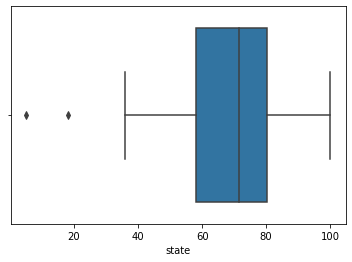

AI-4-v2-1-4: Wie gut hast du jetzt verstanden, was KI ist?
min: 40
max: 100
median: 86.0
mean: 79.06451612903226
std: 19.131014058975836


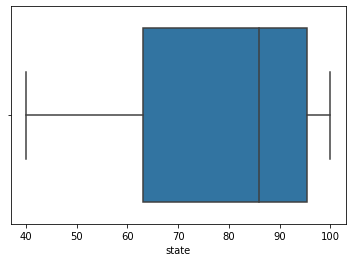

AI-4-v2-1-5: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
min: 33
max: 100
median: 88.0
mean: 78.96774193548387
std: 23.08749137659863


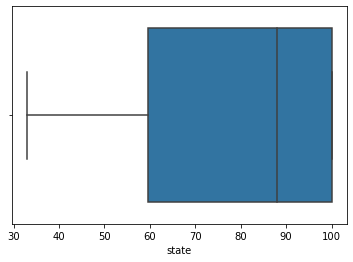

ML-2-1-1: Wie gut weißt du schon, was Maschinelles Lernen ist?
min: 47
max: 100
median: 68.5
mean: 70.21428571428571
std: 17.531679564713368


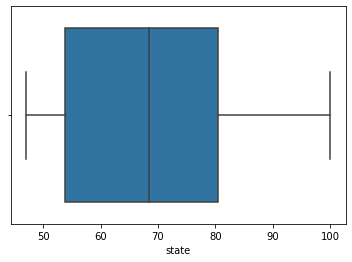

EvalML-1-1: Wie gut hast du verstanden, was KI ist? Sei dabei so ehrlich es geht damit wir diese Inhalte noch verbessern können.
min: 31
max: 100
median: 77.5
mean: 71.5
std: 24.339742745622374


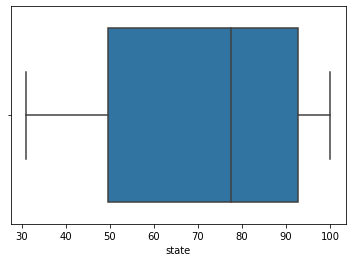

EvalML-1-2: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
min: 1
max: 100
median: 87.0
mean: 73.78571428571429
std: 32.232755846352156


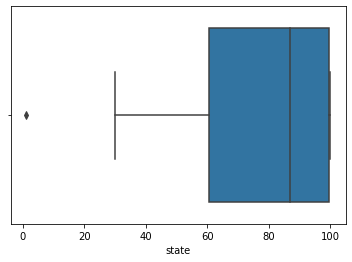

EvalML-1-5: Wie gut hast du verstanden, was maschinelles Lernen ist? Sei dabei so ehrlich es geht, damit wir diese Inhalte noch verbessern können.
min: 24
max: 100
median: 74.5
mean: 69.78571428571429
std: 23.855909029093727


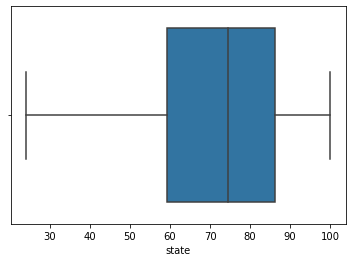

EvalML-1-6: Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?
min: 37
max: 100
median: 79.5
mean: 76.21428571428571
std: 22.112226243654195


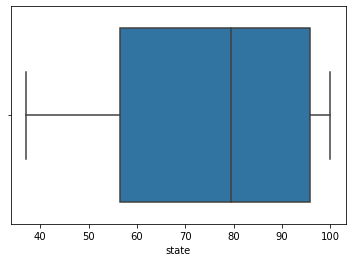

Impact-2-1-2: Ich würde gerne in einem Land leben, dass den Alltag aller Bürger mit KI überwacht.
min: 1
max: 100
median: 16.5
mean: 21.181818181818183
std: 23.613225437970463


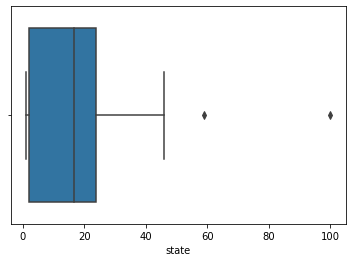

Impact-2-1-3: Die Überwachung des Alltags aller Bürger sehe ich sehr kritisch.
min: 15
max: 100
median: 80.5
mean: 78.13636363636364
std: 22.476009335978567


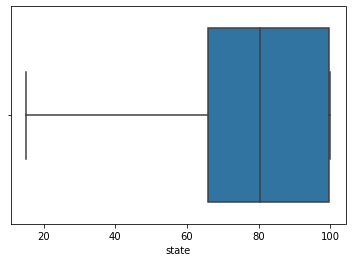

Impact-2-1-4: Mich würde es stören, mittels KI-Technologien überwacht zu werden.
min: 15
max: 100
median: 83.0
mean: 77.72727272727273
std: 24.765917090845825


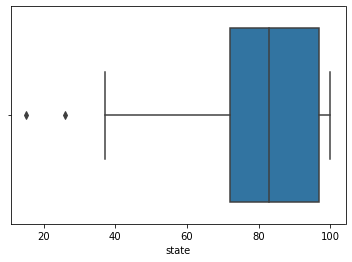

Impact-2-1-5: Die Überwachung durch die Regierung bietet viele Vorteile für die Gesellschaft.
min: 1
max: 85
median: 39.5
mean: 38.13636363636363
std: 27.18244436001445


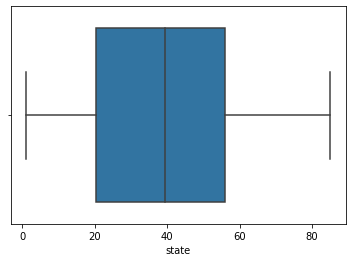

Impact-2-1-6: Ich würde nicht in einem Land leben wollen, dass meinen Alltag überwacht.
min: 1
max: 100
median: 84.0
mean: 75.95454545454545
std: 28.36744826754992


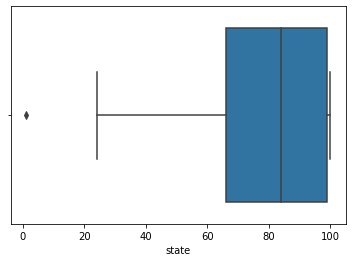

Impact-2-1-7: In einem Land mit Überwachung würde ich mich sehr sicher fühlen.
min: 1
max: 83
median: 41.5
mean: 39.81818181818182
std: 26.865868528206786


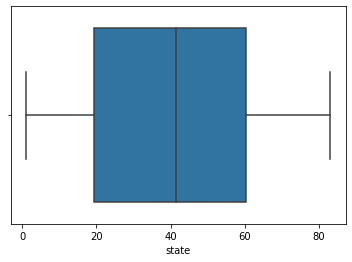

AIClosing-1-1: KI wird das Leben der Menschen verbessern.
min: 1
max: 100
median: 73.0
mean: 67.26315789473684
std: 30.28722155420804


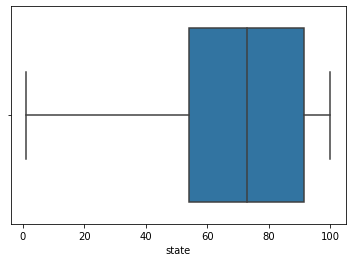

AIClosing-1-2: Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
min: 55
max: 100
median: 71.0
mean: 76.57894736842105
std: 17.014098041440302


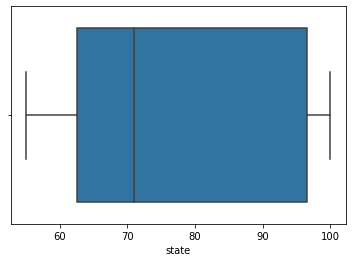

AIClosing-1-3: KI birgt eine Gefahr für die Menschheit.
min: 21
max: 100
median: 54.0
mean: 54.0
std: 22.698507048310958


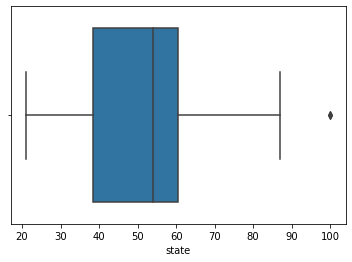

AIClosing-1-4: Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.
min: 1
max: 100
median: 54.0
mean: 56.89473684210526
std: 29.542614675606238


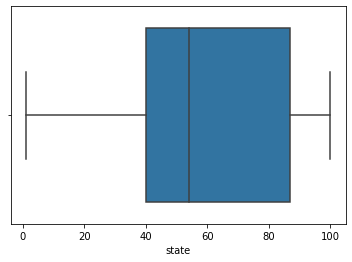

AIClosing-1-6: Hattest du Spaß?
min: 36
max: 100
median: 67.0
mean: 69.6842105263158
std: 20.0860720997825


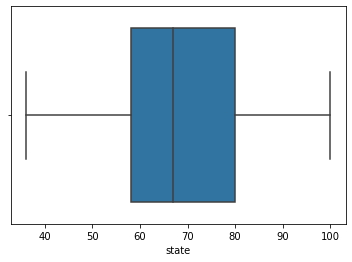

AIClosing-1-7: Hast du etwas gelernt?
min: 1
max: 100
median: 75.0
mean: 75.94736842105263
std: 23.02045873712851


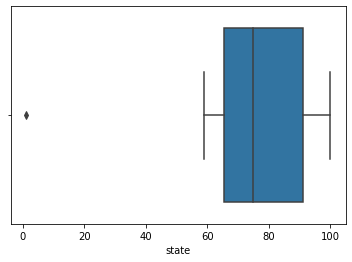

In [9]:
surveysliders = df[df["subType"]=="surveySlider"]
#surveysliders_by_taskId = df[df["subType"]=="surveySlider"].groupby("taskId")

for i in surveysliders["taskId"].unique():
    print(surveysliders[surveysliders["taskId"] == i]["taskId"].unique()[0] + ": " + surveysliders[surveysliders["taskId"] == i]["question"].unique()[0])
    print("min: " + str(surveysliders[surveysliders["taskId"] == i]["state"].min()))
    print("max: " + str(surveysliders[surveysliders["taskId"] == i]["state"].max()))
    print("median: " + str(surveysliders[surveysliders["taskId"] == i]["state"].median()))
    print("mean: " + str(surveysliders[surveysliders["taskId"] == i]["state"].mean()))
    print("std: " + str(surveysliders[surveysliders["taskId"] == i]["state"].std()))
    ax = sns.boxplot(x=surveysliders[surveysliders["taskId"] == i]["state"])
    plt.show()


## MC
### Barplot

['Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI', 'Die Personalisierung einer Google-Anfrage nutzt KI', 'Gesichtserkennung nutzt KI', 'Der Newsfeed eines Social Network nutzt KI']


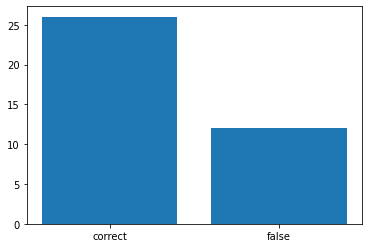

['Die Anwendung, die den Facebook-Feed erstellt, kann auch Schach spielen', 'Eine Sprachsteuerung wie Siri oder Alexa kann auch Gesichter erkennen', 'Das Programm zur Gesichtserkennung auf deinem Handy kann auch Auto fahren']


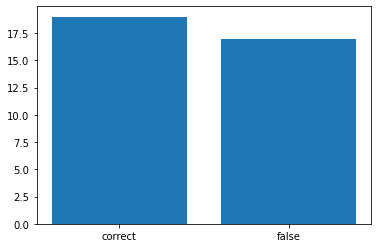

['Empfehlungssysteme gehören zur spezifischen KI', 'Programme zur Bilderkennung gehören zur allgemeinen KI', 'Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI']


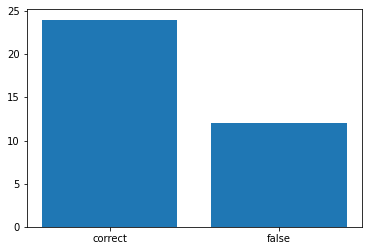

['Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten', 'KI-Anwendungen sind allgemein intelligent', 'KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich', 'Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen']


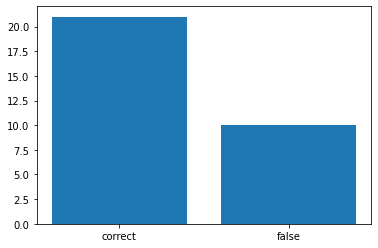

['KI-Anwendungen treffen eigenständige Entscheidungen', 'Heutige KI-Anwendungen gehören alle zur spezifischen KI', 'Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen', 'Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht', 'Ein Spam-Filter ist eine allgemeinen KI', 'Intelligentes Verhalten setzt allgemeine Intelligenz voraus', 'KI-Anwendungen lernen durch Erfahrung']


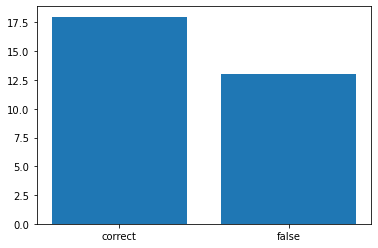

['Unser Ziel ist es, einen Algorithmus zu trainieren, der für neue Bilder das richtige Label vorhersagen kann. Also zu sagen, ob ein Bild einen Hund oder eine Katze zeigt', 'Für das Training nutzen wir Daten ohne Label', 'Nach dem Training testen wir nochmal auf ein paar neuen Daten, wie gut die Vorhersagen des Algorithmus sind', 'Die Daten, die wir für das Training benutzen, heißen Trainingsdaten']


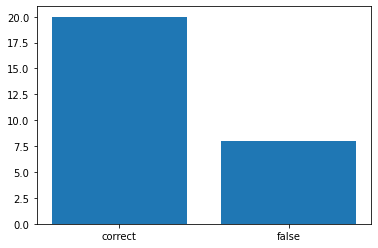

['Das überwachte und das unüberwachte Lernen unterscheiden sich zum Beispiel daran, dass wir einmal Daten mit und einmal Daten ohne Label nutzen', 'Maschinelles Lernen ist ein Teilbereich der KI', 'Das maschinelle Lernen beschäftigt sich mit Programmen, die selbständig in großen Datenmengen Gesetzmäßigkeiten erkennen können', 'Beim unüberwachten Lernen wollen wir lernen, für neue Daten das richtige Label vorherzusagen']


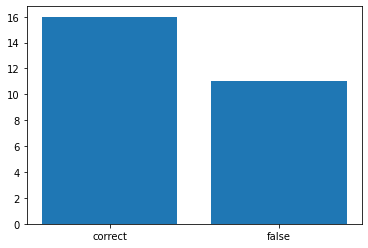

['Unüberwachtes Lernen', 'Überwachtes Lernen']


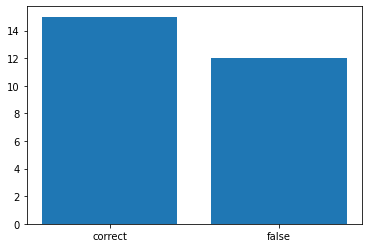

['Unüberwachtes Lernen', 'Überwachtes Lernen']


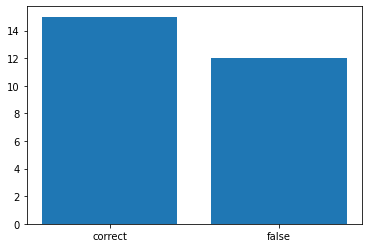

['Unüberwachtes Lernen', 'Überwachtes Lernen']


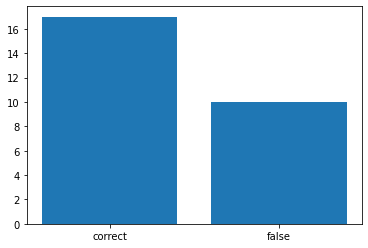

['Beim überwachten Lernen versucht man Struktur in Daten zu finden', 'Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen', 'Beim überwachten Lernen braucht man Daten ohne Label']


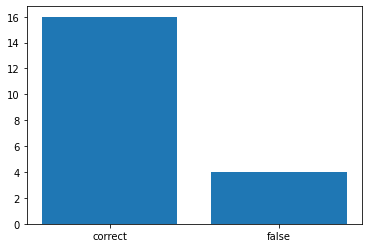

['Beim unüberwachten Lernen nutzt man Daten mit Label', 'Beim unüberwachten Lernen hat man keine Label für die Daten', 'Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden', 'Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen']


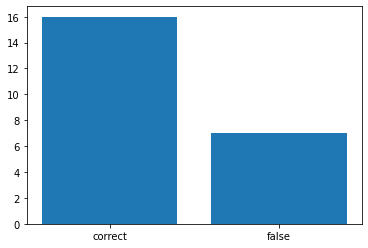

['Die Youtuber im roten Cluster laden öfter Videos hoch', 'Die Youtuber im blauen Cluster laden öfter Videos hoch']


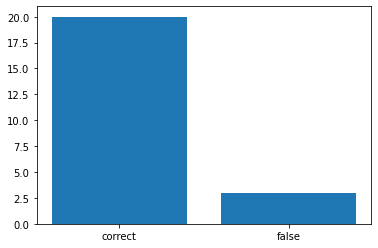

['Anna', 'Isa', 'Paul', 'Josi', 'Mahmud']


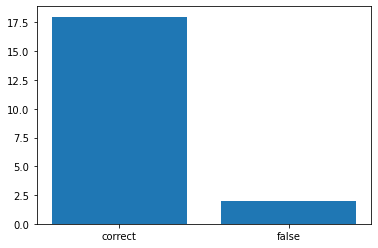

['James Bond', 'Hangover', 'Herr der Ringe', 'Fluch der Karibik', 'Avengers Endgame']


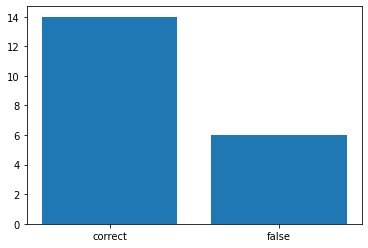

['Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen', 'Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen', 'Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen']


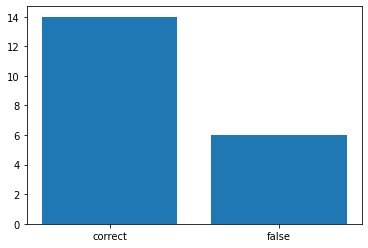

['Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig', 'Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind', 'Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen']


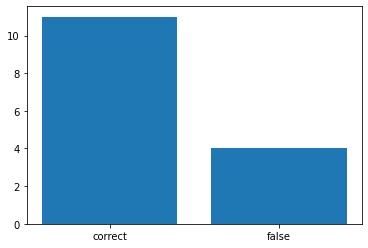

['KI kann irgendwann alles besser als der Mensch', 'Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen', 'Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI', 'Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören', 'Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI', 'Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist', 'Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren', 'KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen', 'Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich']


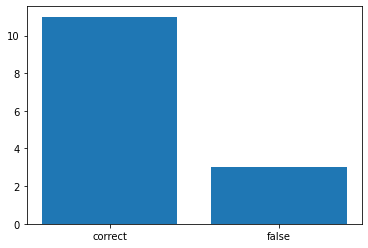

['Die Erkennung von Gegenständen auf Bildern', 'Ein personalisiertes Empfehlungssystem für Musik', 'Das Sortieren von Bildern nach Datum', 'Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert']


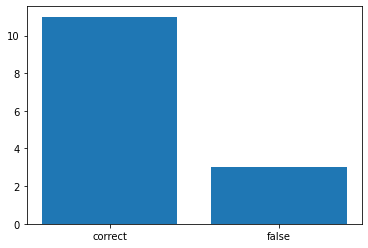

['Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering', 'Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen', 'Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen', 'Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig', 'Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken', 'Clustering ist ein Beispiel für unüberwachtes Lernen', 'Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen', 'Beim überwachten Lernen nutzen wir Daten ohne Label']


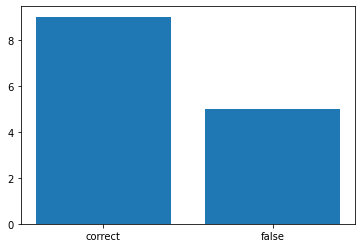

['Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering', 'Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen']


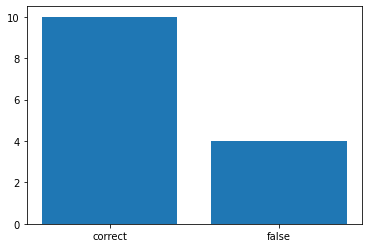

['Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen', 'Der Algorithmus wurde falsch programmiert']


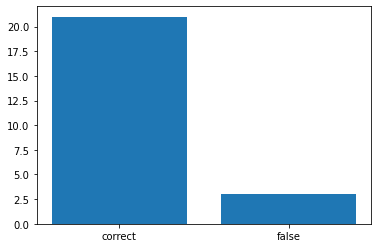

['LKW- und Taxifahrer', 'Lehrer', 'Wissenschaftler', 'Angestellte bei einer Bank oder Versicherung', 'Angestellte im Kundenservice', 'Pflegepersonal']


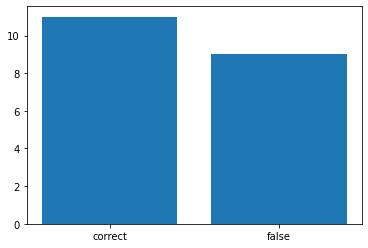

['KI kann helfen, die Behandlungen besser an jeden einzelnen Patienten anzupassen', 'KI kann helfen, die richtigen Behandlungen zu empfehlen', 'KI kann die medizinische Versorgung günstiger machen', 'KI kann helfen, bessere Diagnosen zu stellen', 'KI-Methoden werden Ärzte komplett ersetzen', 'KI kann die Erkennung von Tumoren auf Scans verbessern', 'KI-Methoden können immer die richtige Diagnose stellen']


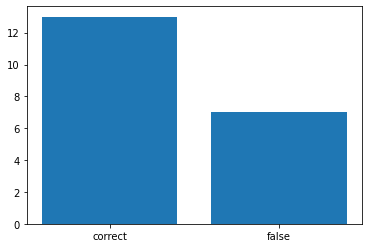

['Drehe nach links', 'Bremsen', 'Gib Gas', 'Gehe Vorwärts']


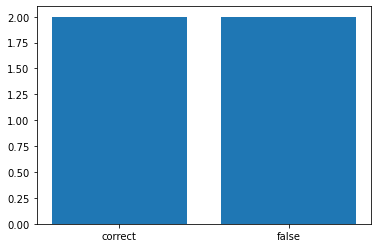

['Ein Programm ist eine Abfolge von Anweisungen, um mithilfe eines Computers ein bestimmtes Ziel zu erreichen oder Problem zu lösen', 'Ein Programm besteht aus Blöcken, die Fahrzeuge zum Ziel führen']


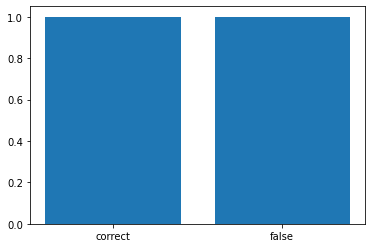

['Sie bestehen aus einzelnen Schritten, die nacheinander ausgeführt werden', 'Algorithmen werden nur von Computern ausgeführt', 'Programme werden nur von Computern ausgeführt', 'Algorithmen gibt es schon viel länger als Programme']


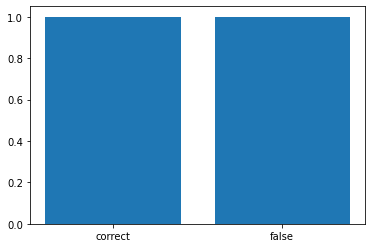

['Es könnte zu unterschiedlichen Ergebnissen kommen', 'Es wird immer zum gleichen Ergebnis kommen']


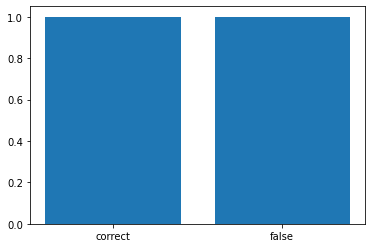

KeyError: 'de'

In [62]:
multipleChoice = df[df["subType"]=="multipleChoice"]
#surveysliders_by_taskId = df[df["subType"]=="surveySlider"].groupby("taskId")

for i in multipleChoice["taskId"].unique():
    #print(multipleChoice[multipleChoice["taskId"] == i]["question"].unique()[0])
    answers = []
    #print(multipleChoice[multipleChoice["taskId"] == i]["answers"])
    #print(len(multipleChoice[multipleChoice["taskId"] == i]["answers"]))
    for answer in multipleChoice[multipleChoice["taskId"] == i]["answers"]:
        for answeritem in answer:
            #print(answeritem)
            answers.append(answeritem["de"])
    #print(len(answers))
    print(list(set(answers)))
    #sns.barplot(x="day", y="total_bill", data=tips)
    #sns.barplot(data=np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.bar(["correct", "false"], np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.show()

### True - False Ratio, Torten

In [88]:
for i in multipleChoice["taskId"].unique():
    if("correct" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()["correct"]/multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()["false"])
    elif("correct" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and not "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys())
    elif("correct" not in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys())

7.333333333333333
2.0
5.0
2.6666666666666665
1.4444444444444444
9.0
2.6
1.0
0.8
8.0
15.0
3.5
Index(['correct'], dtype='object')
15.0
4.333333333333333
7.0
4.5
0.25
9.0
0.6666666666666666
9.0
Index(['correct'], dtype='object')
6.0
1.3333333333333333
